In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K
import sys
import datetime

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# Check used versions
now = datetime.datetime.now()
print("Date-time           ", now)
print("Tf version:         ", keras.__version__)
print("Numpy version:      ", np.__version__)
print("Python              ", sys.executable)
print("Python version      ", sys.version)

Date-time            2021-08-02 11:59:56.844875
Tf version:          2.3.0-tf
Numpy version:       1.19.1
Python               /net/software_g4rt/anaconda3/envs/condaenv-sificcnn/bin/python
Python version       3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]


In [3]:
%%time
# model name
model_name = 'model-2b-lsr-enough-repro'

shuffle_clusters = False

# load the training data
data = DataModel('data-enough-8cl-emax.npz', 
                 batch_size = 128, validation_percent = .05, test_percent = .1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 2
ai.weight_pos_x = 2.5
ai.weight_pos_y = 1
ai.weight_pos_z = 2
ai.weight_energy = 1.5
ai.weight_e_cluster = 1
ai.weight_p_cluster = 1

# randomly shuffle the training data
#np.random.seed(888)
#ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

CPU times: user 2.28 s, sys: 730 ms, total: 3.01 s
Wall time: 3.01 s


In [4]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [5]:
%%time
# compile the ai
ai.compile_model(learning_rate=0.0003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 90:
        return .0003
    elif epoch < 160:
        return .0001
    elif epoch < 180:
        return .00003
    elif epoch < 190:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

CPU times: user 15 ms, sys: 260 µs, total: 15.2 ms
Wall time: 13.9 ms


In [6]:
%%time
#TRAINING
# start the training
#ai.train(epochs=200, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs


In [7]:
ai.load(model_name, optimizer=False)

In [8]:
#ai.evaluate()

In [9]:
# plot the training loss
#ai.plot_training_loss(smooth=False)

In [10]:
ai.isInsideVolume(mask = 'type', data = 'prediction')

In [11]:
ai.isInsideVolume(mask = 'type', data = 'true')

In [12]:
ai.isInsideVolume(mask = 'all', data = 'true')

In [13]:
ai.isInsideVolume(mask = 'all', data = 'prediction')

In [14]:
ai.isInsideVolume(mask = '')

Check argument of arccos: Invalid events 123  from  15383
  Number of valid events (arccos): 15260.00000
  Number of valid events (arccos): 7378.00000       
  Number of valid events (arccos):  0.00000       
  Sanity check (No. y_OM larger y_OC): 7378.00000   
  No. axis missed, pos y_OC, 0 tolerance:  0.00000
  No. axis missed, pos y_OC, 5 tolerance:  0.00000
  No. axis missed, neg y_OC, 0 tolerance: 424.00000
  No. axis missed, neg y_OC, 5 tolerance: 96.00000


No handles with labels found to put in legend.


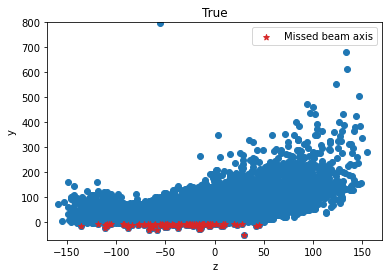

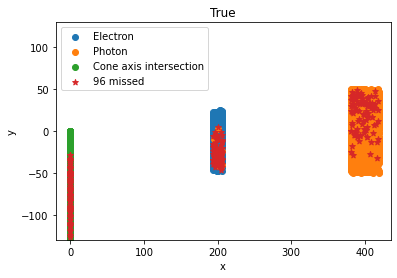

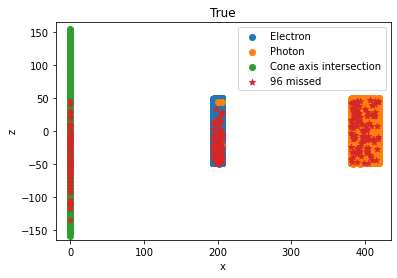

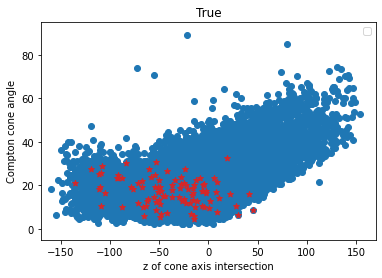

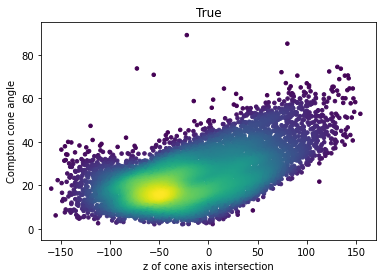

In [15]:
# Plotted: Negative cone axis intersection with x=0 plane, forward scattering

#ai.savefigpath = '/home/home2/institut_3b/profe/Data/SiFiCCNN/21-07-EventAnalysis-ComptonConeDirection/Negative_Yoc_Forward/'
ai.evaluationComptonCones(mask = 'type', events = 'True', save = False) # with Rotation matrix

In [16]:
#ai.evaluationComptonCones(mask = 'position', events = 'True', save = True) 

In [17]:
#ai.evaluationComptonCones(mask = 'all', events = 'True', save = True) 

Check argument of arccos: Invalid events 56  from  15383
  Number of valid events (arccos): 15327.00000
  Number of valid events (arccos): 7521.00000       
  Number of valid events (arccos):  0.00000       
  Sanity check (No. y_OM larger y_OC): 7521.00000   
  No. axis missed, pos y_OC, 0 tolerance:  0.00000
  No. axis missed, pos y_OC, 5 tolerance:  0.00000
  No. axis missed, neg y_OC, 0 tolerance: 324.00000
  No. axis missed, neg y_OC, 5 tolerance: 205.00000


No handles with labels found to put in legend.


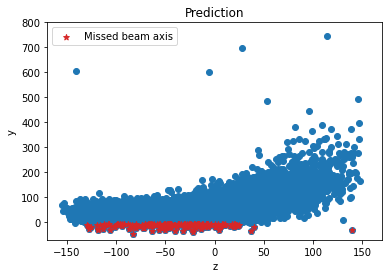

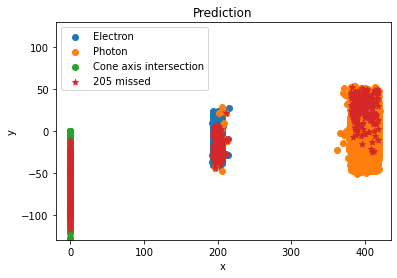

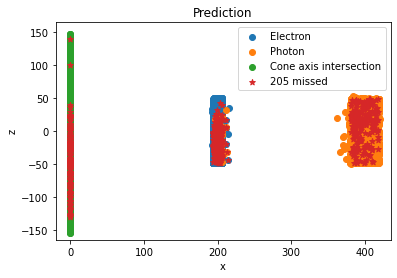

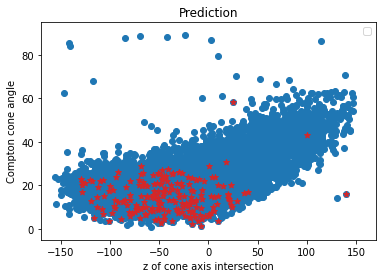

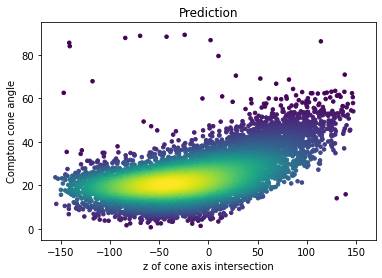

In [18]:
ai.evaluationComptonCones(mask = 'type', events = 'Prediction', save = False)

In [19]:
#ai.evaluationComptonCones(mask = 'position', events = 'Prediction', save = True)

In [20]:
#ai.evaluationComptonCones(mask = 'all', events = 'Prediction', save = True)

In [21]:
# evaluate the AI on the test dataset
#ai.evaluate()

In [22]:
# save the trained model
#ai.save(file_name=model_name)